# Workshop Deep Learning

Dieses Tutorial zeigt, wie man mittels eines Neuronalen Netzwerks / Deep Learning einen Bild-Klassifizierer baut, der Katzenbilder von Hundebildern unterscheidet.

Diese Aufgabenstellung kommt aus dem ["Cats vs. Dogs"](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) Wettbewerb der Website Kaggle.

Basis bildet ein Convolutional Neuronal Network (CNN) namens "VGG16", welches auf Basis der Daten des [Imagenet Datasets](http://image-net.org/synset?wnid=n02084071) vortrainiert wurde. Das Modell wird durch Umkonfiguration und Re-Training so angepasst, dass es die gestellte Aufgabe lösen kann.

Die Grundlagen zu diesem Workshop kommen aus dem Deep Learning MOOC [fast.ai](http://fast.ai).

## Inhalt

1. [Data preparation](#Data-preparation) - Welche Daten verarbeiten wir?
1. [Setup](#Setup) - Initialisierung der notwendigen Frameworks und des Modells
1. [Training](#Training) - Training des Modells mit unseren Daten
1. [Vorhersage](#Vorhersage) - Das trainierte Modell anwenden, um eine Vorhersage zu treffen
1. [Visualisieren der Ergebnisse](#Visualisieren-der-Ergebnisse) - Wir schauen uns an, welche Ergebnisse das Modell liefert
1. [Mehr Layer trainieren](#Mehr-Layer-trainieren) - Das Training intensivieren
1. [Exkurs: Wenige Bilder Trainieren, viele Bilder klassifizieren](#Exkurs:-Wenige-Bilder-Trainieren,-viele-Bilder-klassifizieren)


## Data preparation

Die Daten des Kaggle Wettbewerbs wurden schon vorbereitet und in der "richtigen" Struktur abgelegt.
Das Verzeichnis `data` enthält die Trainings- und Validierungsdaten aus dem Dataset. Dabei sind die Bilder zu jeder zu erkennenden "Klasse" (Cats & Dogs in unserem Fall) in einem eigenen Unterverzeichnis abgelegt:

In [1]:
# ! führt einen Shell-Befehl aus...
!tree -d data

data
├── results
│   ├── filenames.dat
│   │   ├── data
│   │   └── meta
│   └── predictions.dat
│       ├── data
│       └── meta
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

15 directories


Mal schauen, wieviele Dateien in den Trainings- und Validerungsdaten drin sind:

In [4]:
!echo -n "Training cats: " && ls data/train/cats | wc -w
!echo -n "Training dogs: " && ls data/train/dogs | wc -w
!echo -n "Validation cats: " && ls data/valid/cats | wc -w
!echo -n "Validation dogs: " && ls data/valid/dogs | wc -w

Training cats: 11567
Training dogs: 11433
Validation cats: 933
Validation dogs: 1067


Das Verzeichnis `test` enthält die Bilder, die nicht klassifizert sind (deshalb das Unterverzeichnis `unknown`). Diese wollen wir nach dem Training bestimmen. Mal sehen, wieviele das sind:

In [5]:
!echo -n "Test: " && ls data/test/unknown | wc -w

Test: 12500


Damit wir am Code herumprobieren können, ohne gleich lange Laufzeiten aufgrund der vielen Dateien zu erhalten, gibt es noch ein `sample` Dataset, welches gleich aufgebaut ist, aber nur nur einen kleinen Teil der Daten enthält:

In [6]:
!tree -d sample

sample
├── results
│   ├── expected-train.dat
│   │   ├── data
│   │   └── meta
│   ├── filenames.dat
│   │   ├── data
│   │   └── meta
│   ├── predictions.dat
│   │   ├── data
│   │   └── meta
│   └── preds-train.dat
│       ├── data
│       └── meta
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

21 directories


In [7]:
!echo -n "Training cats: " && ls sample/train/cats | wc -w
!echo -n "Training dogs: " && ls sample/train/dogs | wc -w
!echo -n "Validation cats: " && ls sample/valid/cats | wc -w
!echo -n "Validation dogs: " && ls sample/valid/dogs | wc -w
!echo -n "Test: " && ls sample/test/unknown | wc -w

Training cats: 100
Training dogs: 100
Validation cats: 25
Validation dogs: 25
Test: 25


## Setup

Diesen Teil immer ausführen. Hier werden notwendige Packete geladen und globale Variablen initialisiert.

In [1]:
%matplotlib inline

In [2]:
from glob import glob
import numpy as np
import shutil
import os.path
import time

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import utils
import keras
import sklearn

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Hier setzen wir den Pfad für die Daten, mit denen wir arbeiten wollen (also `data` oder `sample`):

In [7]:
# path = "data/"
path = "sample/"
path = os.path.join(os.path.curdir,path)
print path

train_path = os.path.join(path,"train")
valid_path = os.path.join(path,"valid")
test_path = os.path.join(path,"test")
result_path = os.path.join(path,"results")

print train_path
print valid_path
print test_path
print result_path

./sample/
./sample/train
./sample/valid
./sample/test
./sample/results


Wir laden die Python Klasse, welche das Modell (ein Convolutional Neuronal Network - CNN) in ein nettes, mehr oder weniger objektorientiertes API verpackt. Der Sourcecode dazu steht in der Datei `vgg16.py`.

In [2]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

# Wie viele Durchläufe durch die Trainingsdaten sollen gemacht werden:
epochs = 1

# Import VGG16 class, and instantiate
import vgg16
vgg = vgg16.Vgg16()

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Das VGG16 Modell wurde an der University of Oxford von der [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) entwickelt und veröffentlicht. Es wurde verwendet um den [Imagenet Contest](http://image-net.org/synset?wnid=n02084071) zu gewinnen. Es erkennt 1000 verschiedene Ojekte (= es liefert zu einem Bild 1000 Wahrscheinlichkeitswerte, ob das Bild ein Ding dieser Klasse enthält).

Wir können einen Blick in den Code der Klasse werfen (?? zeigt die Implementierung eines Code-Elements):

In [3]:
??vgg

Wir laden die Trainings- und Validierungsdaten als "Batches". `vgg.get_batches()` setzt voraus, dass die Daten in Unterverzeichnissen je Kategorie abgelegt sind. Genau das ist bei uns der Fall, wie wir oben gesehen haben ("cats" und "dogs").

In [8]:
train_batches = vgg.get_batches(train_path, batch_size=batch_size)
validation_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)


Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Training

Dann wird das VGG16 Modell an unsere Aufgabe ("cat or dog" Klassifizierung) angepasst: `vgg.finetune()`. Dies ändert die Architektur des Netzes: Der letzte Layer wird verworfen und durch einen neuen Layer erstetzt, welcher nur noch 2 Outputs hat (statt wie bisher 1000): Cats & Dogs!

In [9]:
vgg.finetune(train_batches)

Wir können uns anschauen, was die Methode `finetune` macht:

In [4]:
??vgg.finetune

Der eigentliche Austausch des letzten Layers erfolgt in der Methode `vgg.ft()`. Die Gewichte des neuen Layers sind zunächst mit Zufallswerten initialisiert worden, d.h. sie müssen noch trainiert werden. Die anderen Layer lassen wir, wie sie sind (`layer.trainable = False`).

In [10]:
??vgg.ft

Jetzt trainieren wir das Modell mit den Daten über `vgg.fit()`. Dabei wird in Wahrheit nur noch der letze (modifizierte) Layer des angepassten VGG16 Modells trainiert. Die angepassten Gewichte des Modells schreiben wir in eine Datei, so dass wir sie später wieder laden können und so nicht jedesmal das Training wiederholen müssen.

In [12]:
# Learning rate:
vgg.model.optimizer.lr = 0.01

print('start fitting at {}'.format(time.asctime()))

vgg.fit(train_batches, validation_batches, nb_epoch=3)

print('stop fitting at {}'.format(time.asctime()))
weights_filename = os.path.join(result_path,'finetune1.h5')
print 'saving weights to {}'.format(weights_filename)
vgg.model.save_weights(weights_filename)

start fitting at Wed Jan 17 09:55:27 2018
Epoch 1/3
200/200 [==============================] - 8s - loss: 0.2961 - acc: 0.9550 - val_loss: 1.3280e-06 - val_acc: 1.0000
Epoch 2/3
200/200 [==============================] - 7s - loss: 0.1646 - acc: 0.9850 - val_loss: 6.9261e-07 - val_acc: 1.0000
Epoch 3/3
200/200 [==============================] - 7s - loss: 0.1282 - acc: 0.9850 - val_loss: 1.9980e-06 - val_acc: 1.0000
stop fitting at Wed Jan 17 09:55:52 2018
saving weights to ./sample/results/finetune1.h5


## Vorhersage

Jetzt klassifizieren wir mit dem re-trainierten Modell die Bilder, die im Unterverzeichnis 'test' abgelegt sind. Anders ausgedrückt: Wir sagen für eine Menge Daten (= ein Bild) vorher, mit jeweils welcher Wahrscheinlichkeit diese Daten eine Katze bzw. ein Hund ist. Die Ergebnisse speichern wir wieder in Dateien, damit wir später bei Bedarf darauf zugreifen können, ohne das ganze Training wiederholen zu müssen.

In [18]:
# Dateien zum Speichern der Ergebnisse:
predictions_file = os.path.join(result_path,'predictions.dat')
filenames_file = os.path.join(result_path,'filenames.dat')

Prediction durchführen und Ergebnisse speichern:

In [19]:
print('start predicting at {}'.format(time.asctime()))
test_batches, predictions = vgg.test(test_path,batch_size=batch_size*2)
print('stop predicting at {}'.format(time.asctime()))

utils.save_array(predictions_file, predictions)
utils.save_array(filenames_file, test_batches.filenames)

start predicting at Fri Jan 12 10:14:00 2018
Found 25 images belonging to 1 classes.
stop predicting at Fri Jan 12 10:14:04 2018


### Mal ein paar Ergebnisse anschauen

Zunächst eine kleine Hilfsmethode, um Bilder anzeigen zu können:

In [13]:
from keras.preprocessing import image
def plots_idx(idx, path, filenames, titles=None):
    utils.plots([image.load_img(os.path.join(path,filenames[i])) for i in idx], titles=titles)

Wir laden die Ergebnisse aus den oben geschriebenen Dateien:

In [21]:
predictions = utils.load_array(predictions_file)
filenames = utils.load_array(filenames_file)

Wir wählen zufällig ein paar Bilder aus und zeigen sie mit der Vorhersage an (`[Wahrscheinlichkeit Katze, Wahrscheinlichkeit Hund]`).

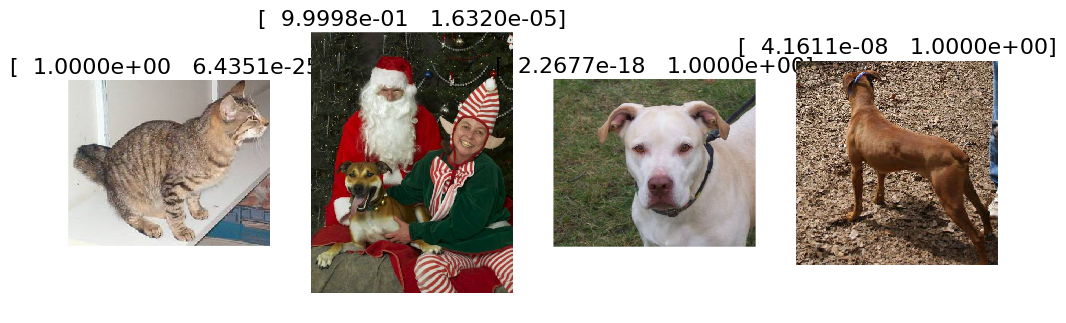

In [24]:
idx = np.random.randint(0, len(test_batches.filenames),4)
plots_idx(idx, path=test_path, filenames=test_batches.filenames, titles=predictions[idx])

## Visualisieren der Ergebnisse

Wir wollen uns anschauen, wie gut unser Modell eigentlich vorhersagt. Die Idee dazu ist, dass wir mit dem Modell eine Vorhersage über die bereits klassifizierten Trainingsdaten machen. So kennen wir die "ground truth" zu jedem Bild und können ermitteln, ob die Vorhersage korrekt war.

Die trainierten Gewichte werden in das Modell geladen:

In [ ]:
# Modell nochmal neu initialisieren (falls wir hier wieder beginnen wollen):
vgg = Vgg16()
# Nicht vergessen, die letzte Schicht zu verändern (2 statt 1000 Klassen als Output)!
vgg.finetune(train_batches)


In [ ]:
weights_filename = os.path.join(result_path,'finetune1.h5')
vgg.model.load_weights(weights_filename)

Vorhersage mit den Validierungsdaten. So kennnen wir die "ground truth" und können sie mit der Vorhersage des Modells vergleichen.

In [26]:
valid_batches, predictions = vgg.test(valid_path, batch_size=64)
expected_labels = valid_batches.classes
filenames = valid_batches.filenames

print predictions[:20]

our_predictions = predictions[:,0]
print our_predictions[:8]
our_labels = np.round(1-our_predictions)
print "is a dog: ", our_labels[:8]

Found 50 images belonging to 2 classes.
[[  1.0000e+00   9.9347e-21]
 [  1.0000e+00   4.6134e-29]
 [  1.0000e+00   2.2977e-23]
 [  1.0000e+00   3.1104e-31]
 [  1.0000e+00   1.5003e-12]
 [  1.0000e+00   2.9217e-30]
 [  1.0000e+00   1.5629e-30]
 [  1.0000e+00   5.2889e-15]
 [  1.0000e+00   3.4975e-16]
 [  1.0000e+00   1.2469e-33]
 [  9.9996e-01   3.6331e-05]
 [  1.0000e+00   1.2660e-33]
 [  1.0000e+00   2.2128e-15]
 [  1.0000e+00   6.6706e-25]
 [  1.0000e+00   2.7794e-21]
 [  1.0000e+00   2.6986e-20]
 [  1.0000e+00   2.2857e-09]
 [  1.0000e+00   7.8869e-37]
 [  1.0000e+00   5.1315e-30]
 [  1.0000e+00   2.4203e-23]]
[ 1.  1.  1.  1.  1.  1.  1.  1.]
is a dog:  [ 0.  0.  0.  0.  0.  0.  0.  0.]


### Zeige einige korrekte Klassifizierungen

Found 48 correct labels


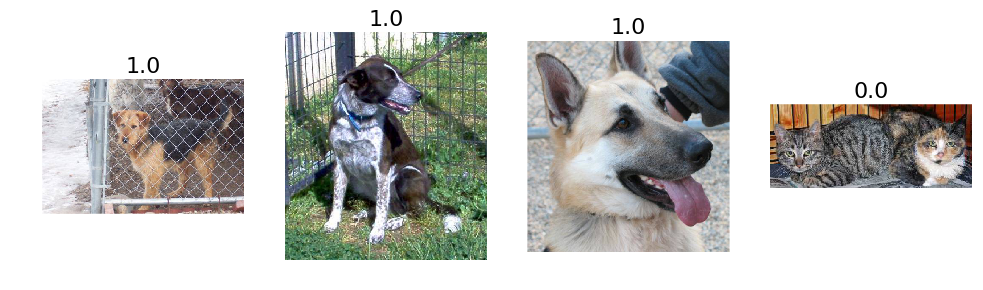

In [28]:
correct = np.where(our_labels==expected_labels)[0]
print "Found {} correct labels".format(len(correct))
idx = np.random.permutation(correct)[:4]
plots_idx(idx, valid_path, filenames, our_labels[idx])

### Zeige einige falsche Klassifizierungen

Found 2 incorrect labels.


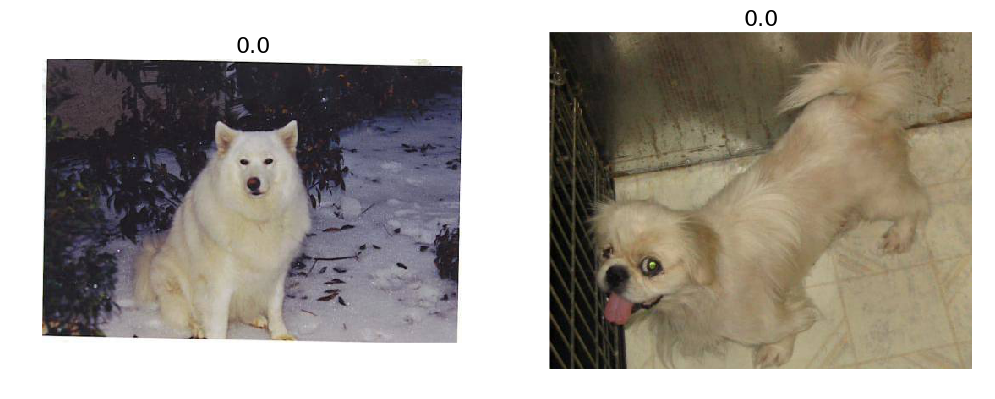

In [29]:
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found {} incorrect labels.".format(len(incorrect))
if len(incorrect)>0:
    idx = np.random.permutation(incorrect)[:4]
    plots_idx(idx, valid_path, filenames, our_labels[idx])

### Zeige einige richtige Klassifizierungen mit der größten Wahrscheintlichkeit

... also da, wo das Modell wirklich recht hatte.

Found 25 confident correct cats labels
Found 23 confident correct dogs labels


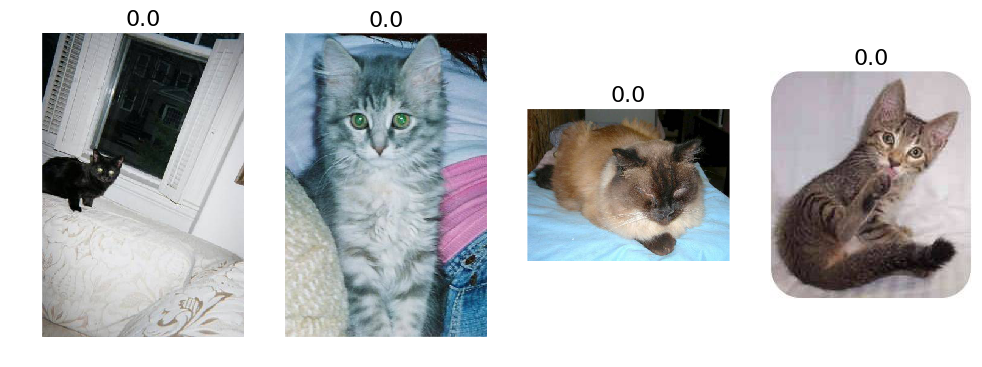

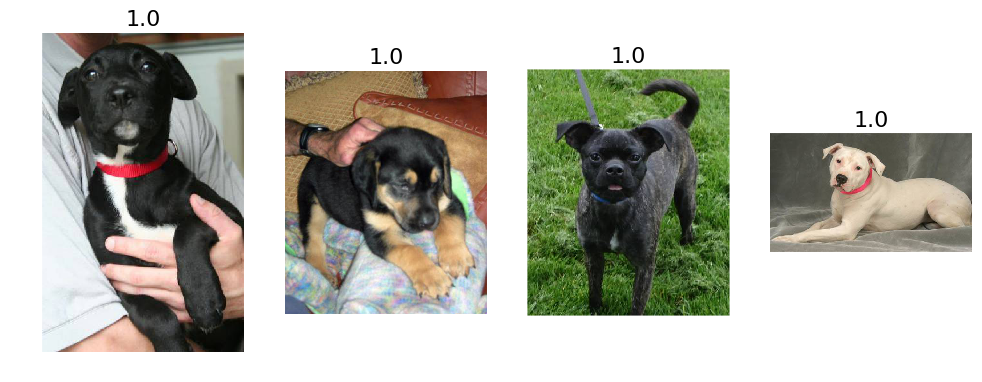

In [30]:
confident_cats = np.where((our_labels==expected_labels) & (our_labels==0))[0]
print "Found {} confident correct cats labels".format(len(confident_cats))
idx = np.random.permutation(confident_cats)[:4]
plots_idx(idx,valid_path, filenames, our_labels[idx])

confident_dogs = np.where((our_labels==expected_labels) & (our_labels==1))[0]
print "Found {} confident correct dogs labels".format(len(confident_dogs))
idx = np.random.permutation(confident_dogs)[:4]
plots_idx(idx,valid_path, filenames, our_labels[idx])

### Ziege einige falsche Klassifizierungen mit der größten Wahrscheinlichkeit

... also die, bei denen das Modell total daneben lag.

Found 2 confident incorrect cats labels
Found 0 confident incorrect dogs labels


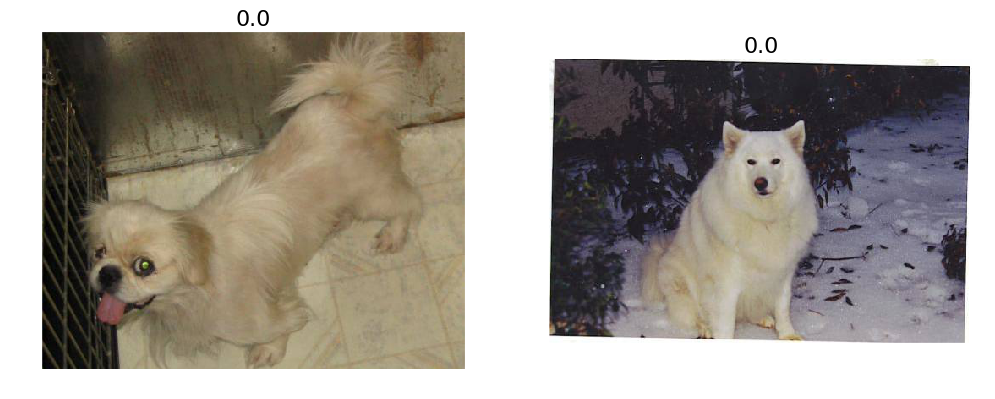

In [31]:
confident_cats = np.where((our_labels!=expected_labels) & (our_labels==0))[0]
print "Found {} confident incorrect cats labels".format(len(confident_cats))
if len(confident_cats)>0:
    idx = np.random.permutation(confident_cats)[:4]
    plots_idx(idx,valid_path, filenames, our_labels[idx])

confident_dogs = np.where((our_labels!=expected_labels) & (our_labels==1))[0]
print "Found {} confident incorrect dogs labels".format(len(confident_dogs))
if len(confident_dogs)>0:
    idx = np.random.permutation(confident_dogs)[:4]
    plots_idx(idx,valid_path, filenames, our_labels[idx])

### Ziege die unsichersten Klassifizierungen

... also die, bei denen sich das Modell nicht so sicher war.

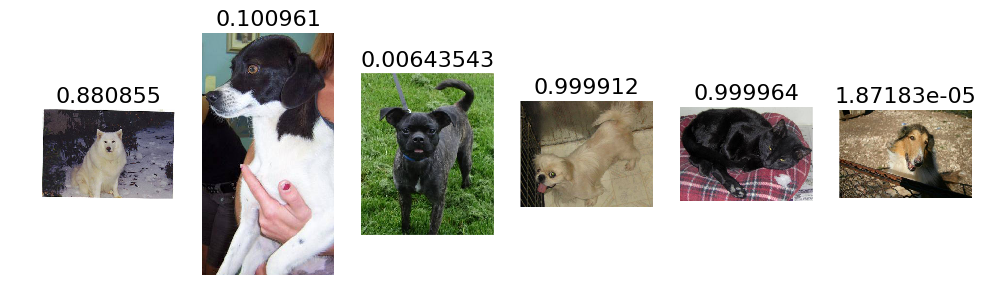

In [32]:
uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(uncertain[:6], valid_path, filenames, our_predictions[uncertain])

### Confusion Matrix

[[25  0]
 [ 2 23]]


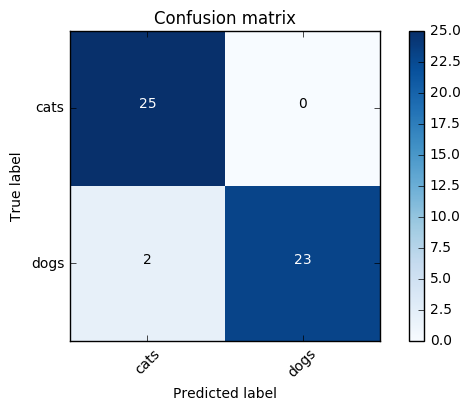

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels,our_labels)
utils.plot_confusion_matrix(cm, valid_batches.class_indices)

## Mehr Layer trainieren

Bisher haben wir nur den letzten Layer des Modells neu trainiert und den Rest des Modells nicht angetastet. Wenn wir nun auch die mittleren Layer re-trainieren wollen geht das mit Keras ziemlich einfach...

Zunächst mal einen Blick auf die Architektur des Modells werfen:

In [37]:
# Modell nochmal neu initialisieren (falls wir hier wieder beginnen wollen):
vgg = vgg16.Vgg16()
# Nicht vergessen, die letzte Schicht zu verändern (2 statt 1000 Klassen als Output)!
vgg.finetune(train_batches)

weights_filename = os.path.join(result_path,'finetune1.h5')
vgg.model.load_weights(weights_filename)

vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

Achtung: Wir müssen darauf achten, den letzten Layer (den wir oben selbst hinzugefügt haben) vorher über `vgg.fit()` auch trainiert zu haben, da er sonst mit Zufallswerten initialisert ist, welche das Training der Zwischenschichten ziemlich durcheinander bringen würde. Wenn wir die zuvor in einer Datei gespeicherten Gewichte verwenden ist das automatisch der Fall.

In [38]:
# Hilfsmethode, um Modell anzupassen (fitting):
def fit_model(model, train_batches, validation_batches, nb_epoch=1):
    model.fit_generator(train_batches, samples_per_epoch=train_batches.N, nb_epoch=nb_epoch, 
                        validation_data=validation_batches, nb_val_samples=validation_batches.N)
    
# Hole den Index des ersten "dense" layers:
first_dense_idx = [index for index,layer in enumerate(vgg.model.layers) if type(layer) is keras.layers.core.Dense][0]
print "First dense layer is layer no. " + str(first_dense_idx)
# ...und setze diesen und alle nachfolgenden auf "trainierbar":
for layer in vgg.model.layers[first_dense_idx:]: layer.trainable=True

First dense layer is layer no. 33


Jetzt trainieren wir _alle_ Layer ab dem ersten "Dense" Layer neu und speichern die Gewichte:

In [39]:
keras.backend.set_value(vgg.model.optimizer.lr, 0.01)
model_file = os.path.join(result_path,'finetune2.h5')

fit_model(vgg.model, train_batches, validation_batches, 3)

vgg.model.save_weights(model_file)

Epoch 1/3
200/200 [==============================] - 8s - loss: 0.5411 - acc: 0.9400 - val_loss: 0.2043 - val_acc: 0.9600
Epoch 2/3
200/200 [==============================] - 7s - loss: 0.3836 - acc: 0.9650 - val_loss: 0.4010 - val_acc: 0.9400
Epoch 3/3
200/200 [==============================] - 7s - loss: 0.5078 - acc: 0.9550 - val_loss: 0.0921 - val_acc: 0.9800


In [ ]:
vgg.model.evaluate_generator(utils.get_batches(dirname=valid_path, shuffle=False, batch_size=batch_size*2), valid_batches.N)

Um das Modell zu beurteilen, machen wir wieder eine Vorhersage über ein klassifziertes Dataset ("ground truth") und berechnen eine Cross Entropy Matrix:

In [40]:
def predict_and_plot_confusion_matrix(vgg, path):
    # Prediction:
    batches, predictions = vgg.test(path, batch_size=64)
    our_predictions = predictions[:,0]
    our_labels = np.round(1-our_predictions)

    # Ground truth:
    expected_labels = batches.classes

    cm = sklearn.metrics.confusion_matrix(expected_labels,our_labels)
    utils.plot_confusion_matrix(cm, batches.class_indices)

Found 50 images belonging to 2 classes.
[[25  0]
 [ 1 24]]


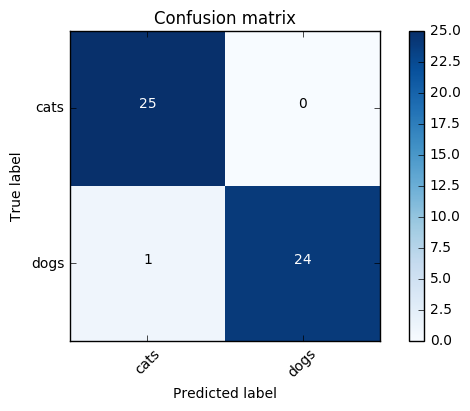

In [41]:
predict_and_plot_confusion_matrix(vgg,valid_path)

Wir können auch probieren, noch mehr Layer zu trainieren (nicht nur die Dense-Layer am hinteren Ende des Networks):

In [42]:
for layer in vgg.model.layers[12:]: layer.trainable=True
keras.backend.set_value(vgg.model.optimizer.lr, 0.001)
model_file = os.path.join(result_path,'finetune3.h5')

fit_model(vgg.model, train_batches, validation_batches, 4)

vgg.model.save_weights(model_file)

Epoch 1/4
200/200 [==============================] - 8s - loss: 0.2428 - acc: 0.9800 - val_loss: 0.0642 - val_acc: 0.9800
Epoch 2/4
200/200 [==============================] - 7s - loss: 0.1200 - acc: 0.9800 - val_loss: 0.0254 - val_acc: 0.9800
Epoch 3/4
200/200 [==============================] - 7s - loss: 0.2439 - acc: 0.9850 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 4/4
200/200 [==============================] - 7s - loss: 0.2191 - acc: 0.9800 - val_loss: 0.0218 - val_acc: 0.9800


Auch hier berechnen wir wieder eine Confusion Matrix:

Found 50 images belonging to 2 classes.
[[24  1]
 [ 0 25]]


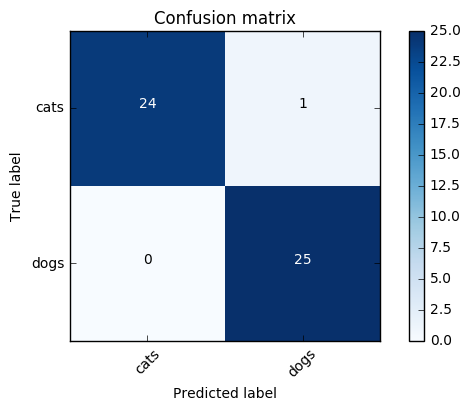

In [43]:
predict_and_plot_confusion_matrix(vgg,valid_path)

## Exkurs: Wenige Bilder Trainieren, viele Bilder klassifizieren

Wie gut ist unser Modell eigentlich, wenn wir nur mit wenigen Bildern trainieren?

Vorgehensweise:
* Trainieren mit den Bildern des `sample` Datasets (200 Bilder)
* Vorhersagen mit den Bildern des normalen Datasets (23000 Trainingsbilder als Ground Truth)

Da wir hier nicht das ganze Training wiederholen wollen, laden wir die Gewichte aus dem `sample` Pfad - das setzt voraus, dass man den Trainings-Code oben auch mal mit dem `sample` Dataset ausgeführt hat.

Found 23000 images belonging to 2 classes.
[[11259   308]
 [  361 11072]]


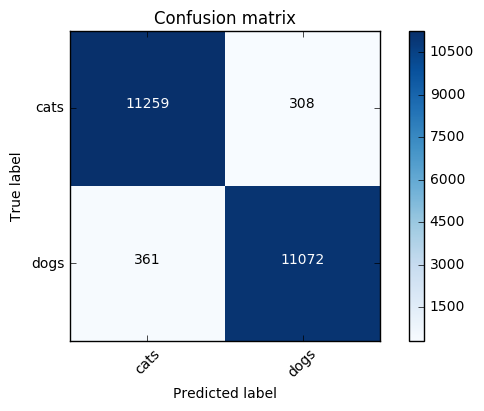

In [44]:
# Modell nochmal neu initialisieren (falls wir hier wieder beginnen wollen):
#vgg_small = vgg16.Vgg16()
# Nicht vergessen, die letzte Schicht zu verändern (2 statt 1000 Klassen als Output)!
#vgg_small.finetune(train_batches)
# Gewichte laden (aus dem 'sample' Pfad!)
#weights_filename = os.path.join('sample','results','finetune1.h5')
#print "using weights " + weights_filename
#vgg_small.model.load_weights(weights_filename)

# Jetzt führen wir die Vorhersage mit dem "normalen" Dataset durch:
predict_and_plot_confusion_matrix(vgg,os.path.join('data','train'))

Das Modell hat also nur ~820 von 23.000 Bildern falsch klassifiziert (~3,6%), obwohl das Finetuning mit nur 200 Bildern erfolgte (nicht vergessen: Das Modell wurde mit den Bildern aus Imagnet vortrainiert!). Dieser Werte lässt sich sicher noch verbessern, wenn wir das Finetuning auch auf andere Layer ausweiten - wie im vorigen Abschnitt beschrieben.